# Exercise 2 
## Learning graphs from high dimensional data.

### Goals

* Introduction to graphtools
* Visualizing graphs
* Understanding parameters of learning graphs




## What is a graph?

A graph, in the mathematical sense, is a collection of nodes and edges. Sometimes nodes are called vertices, and sometimes graphs are called networks, but it's all the same thing. The mathematical notation for a graph is usually:

$$ G = (N,E) $$

Which simple says that a graph $G$ comprises a set of nodes $N$ and edges $E$ connecting nodes. In this workshop, we're only going to consider *undirected graphs*, which treats a connection between two nodes $N_{i}$ and $N_{j}$ as  linking the two nodes in both directions.

Our lab has developed a toolkit for analyzing graphs called [`graphtools`](https://github.com/KrishnaswamyLab/graphtools), and some of the backend is provided by the excellent [`pygsp`](https://github.com/epfl-lts2/pygsp) toolkit. 

## 1. Introduction to working with graphs in Python

### Packages

There are a number of different packages designed for working with graphs in Python. We're going to focus on `pygsp` and `graphtools`. We picked these packages because they provide direct interfaces for some important matrices relevant for working with graphs. The other popular package for working with graphs is `NetworkX`, but it approaches graphs from a network science perspective rather than with a graph theoretic approach.

* `pygsp` - a lightweight toolkit for analysis of signals on graphs
* `graphtools` - a library from the Krishnaswamy lab for learning graphs from data. Built for compatibility for `pygsp`.

#### Installing packages

In [0]:
!pip install --user scprep graphtools

     |████████████████████████████████| 102kB 2.7MB/s 
     |████████████████████████████████| 51kB 6.6MB/s 
     |████████████████████████████████| 1.8MB 8.5MB/s 


Restart the runtime after installing the packages.

#### Loading packages

In [0]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import scprep as scprep
import graphtools as gt

from sklearn import datasets, preprocessing

### Generating data with simple geometry

Here we're going to work with 6 datasets all in $\mathbb{R}^2$ 

1. **Circles** - two circles, one circumscribed by the other
2. **Moons** - Two interleaving half circles
3. **Varied variance blobs** - These blobs each have different variances
4. **Anisotropically distributed blobs** - these blobs have unequal widths and lengths
5. **Regular blobs** - Just three regular blobs
6. **Uniformly sampled square** - Just a single square

Because we're generating these from scratch, we get to change some parameters of their distributions. Generally, we can change:
1. `noise` - the amount of Gaussian noise added to each point
2. `n_samples` - the number of points generated
3. `factor` / `cluster_std` - some parameters affecting shape

In [0]:
np.random.seed(0)
# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 300

# Circles
noisy_circles = datasets.make_circles(n_samples=n_samples, 
                        # Scale factor between inner and outer circle
                        factor=.5,
                        # Gaussian noise added to each point
                        noise=.05)

# Moons
noisy_moons = datasets.make_moons(n_samples=n_samples, 
                                  noise=.05)

# Blobs
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)

# Uniform square
no_structure = np.random.rand(n_samples, 2), None

# Anisotropically distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
# Changes how x1, x2 coordinates are shifted
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)


generated_datasets = {'circles':noisy_circles,
     'moons':noisy_moons,
     'blobs_variance':varied,
     'blobs_skew':aniso,
     'blobs_regular':blobs,
     'uniform':no_structure}

#### Plot each dataset

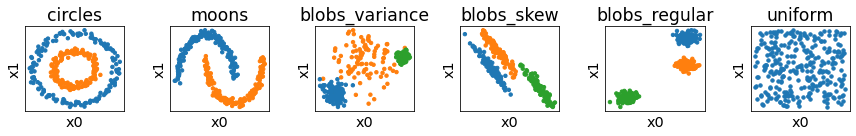

In [0]:
fig, axes = plt.subplots(1,6,figsize=(12,2))

for i, dataset_name in enumerate(generated_datasets):
    ax = axes[i]
    data, group = generated_datasets[dataset_name]
    
    # normalize dataset for easier parameter selection
    data = preprocessing.StandardScaler().fit_transform(data)
    scprep.plot.scatter2d(data, c=group, 
                          ticks=None, ax=ax, 
                          xlabel='x0', ylabel='x1',
                          title=dataset_name,
                         legend=False)
    
fig.tight_layout()

### Learning a graph from data

Let's pick the `blobs_regular` dataset and learn a graph from the data coordinates.

In [0]:
dataset_name = 'blobs_regular'
data, group = generated_datasets[dataset_name]

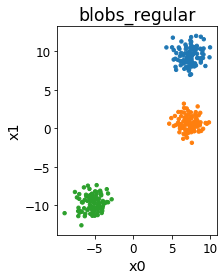

In [0]:
ax = scprep.plot.scatter2d(data, c=group, 
                           xlabel='x0', ylabel='x1',
                           title=dataset_name,
                           legend=False)

# change the shape of the axes to avoid distortion
ax.set_aspect(1)

#### Using `gt.Graph` to fit a graph to the data

Here we're plotting all of the edge weights in the graph. Black lines between points denote affinities close to 1; fainter lines represent values closer to 0. (Affinity is a measure of similarity between points. The higher the affinity is, the more similar the points are. Two points that are the same will have affinity equal to 1.) Drawing every line is slow, so we're only dealing with a few points.

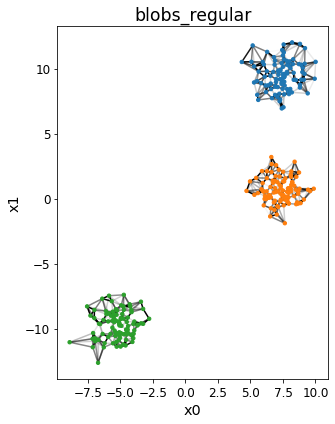

In [0]:
G = gt.Graph(data, knn=5)

# This code draws the nodes of the graph
ax = scprep.plot.scatter2d(data, c=group, 
                           xlabel='x0', ylabel='x1',
                           title=dataset_name, figsize=(8,6),
                           legend=False)

# This block of code draws lines between each point and its neighbors
for i in range(data.shape[0]-1):
    for j in range(i+1, data.shape[0]):
        affinity = G.kernel[i,j]
        if affinity > 0:
            ax.plot(data[[i,j],0], data[[i,j],1],
                    color='black', alpha=affinity, zorder=0)
    
ax.set_aspect(1)
plt.tight_layout()

### See how changing graph parameters affects connectivity

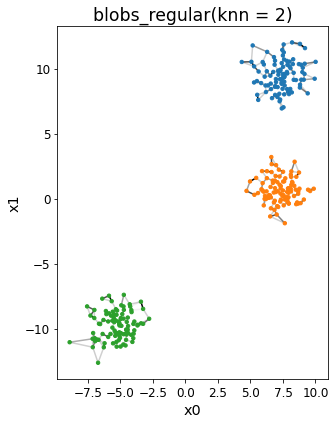

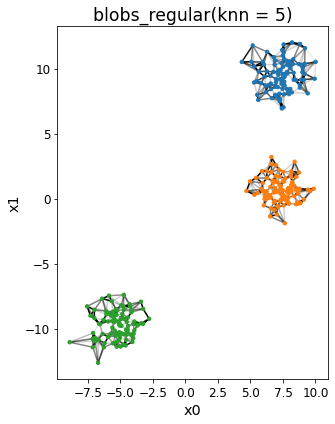

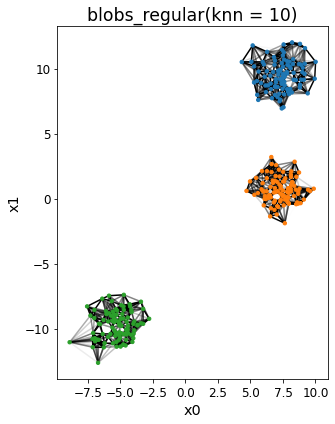

In [0]:
for knn in [2, 5, 10]: 

  G = gt.Graph(data, knn=knn)

  # This code draws the nodes of the graph
  ax = scprep.plot.scatter2d(data, c=group, 
                      xlabel='x0', ylabel='x1',
                      title=dataset_name + "(knn = " + str(knn) + ")", figsize=(8,6),
                      legend=False)

  # This block of code draws lines between each point and its neighbors
  for i in range(data.shape[0]-1):
      for j in range(i+1, data.shape[0]):
          affinity = G.kernel[i,j]
          if affinity > 0:
              ax.plot(data[[i,j],0], data[[i,j],1],
                      color='black', alpha=affinity, zorder=0)
    
  ax.set_aspect(1)
  plt.tight_layout()

### Exercise - graph parameter tuning

In this exercise, we are going to practice learning a graph from synthetic data and see how changing parameters about the data and the graph parameters change the results of the graph.

Each pair per table should:
1. Pick a dataset (each pair should select a different one and not the `blobs_regular`)
2. Copy the code into the following cell
3. Change the parameters for learning the graph (`knn`)
4. Plot the data and determine if the graph looks good (i.e. groups are not connected)
5. Duplicate the code block
6. Change the data generation parameters(`n_samples` and `noise`)
7. Change the graph parameters until you are satisfied with the new graph

Consult the following link for more information about dataset parameters: https://scikit-learn.org/stable/datasets/index.html#generated-datasets

Consider the following questions:
1. If you add noise, how does that affect your choice of `knn`?
2. If you add points, how does that affect your choice of `knn`?
3. Which dataset at your table was the easiest learn a graph from?

**Note: if you create a graph with too many connections, drawing all the edges will be very slow!**

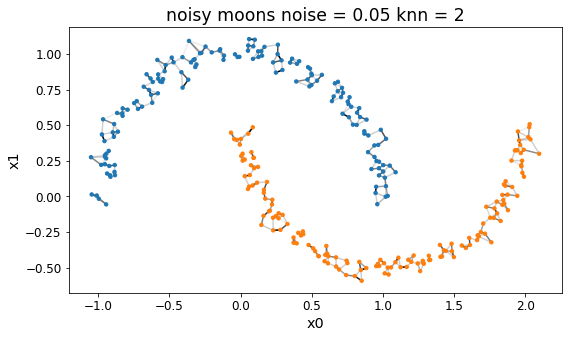

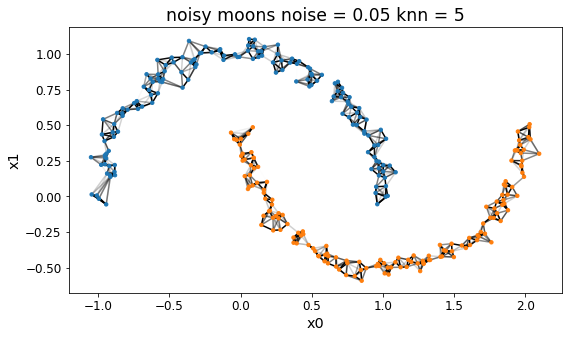

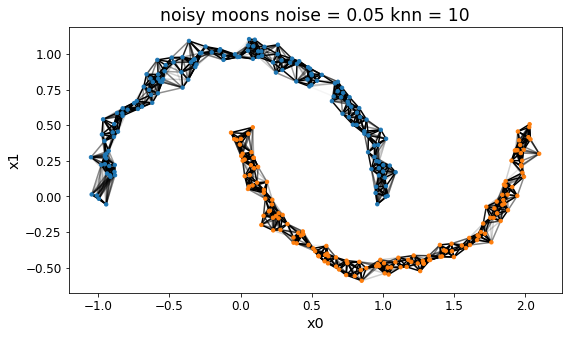

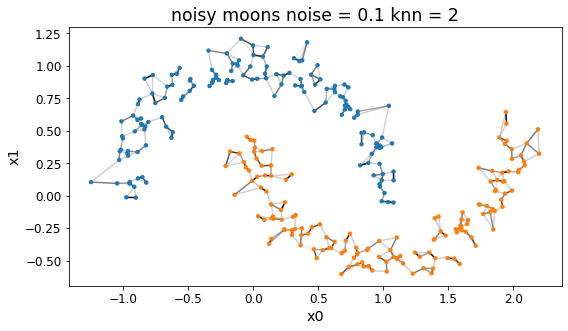

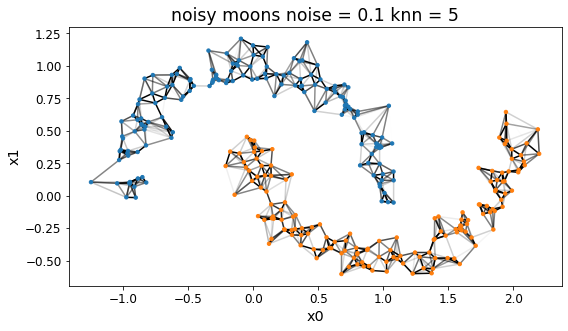

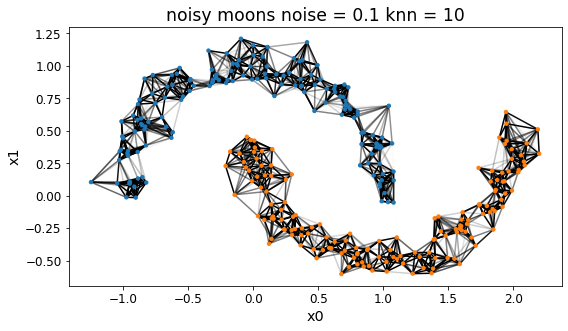

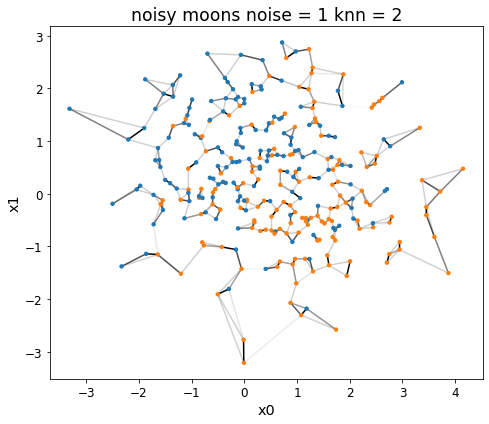

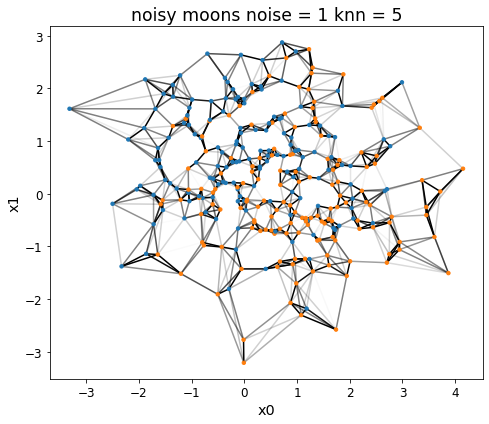

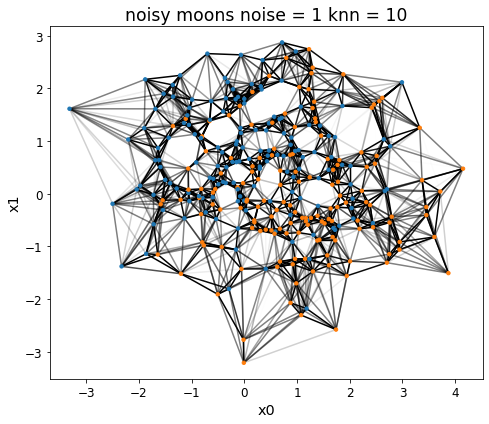

In [0]:
# =======
# Copy + paste the code for generating your chosen dataset below here

# noisy moons
noises = [0.05, 0.1, 1]
knns = [2, 5, 10]
dataset_name = "noisy moons"
for noise in noises:
  data, group = datasets.make_moons(n_samples=n_samples, 
                                  noise=noise)




#========
  for knn in knns:
    G = gt.Graph(data, knn=knn)


# ======
# Plotting the graph
# ======

# This code draws the nodes of the graph
    ax = scprep.plot.scatter2d(data, c=group, 
                      xlabel='x0', ylabel='x1',
                      title= dataset_name + " noise = " + str(noise) + " knn = " + str(knn), figsize=(8,6),
                      legend=False)

# This block of code draws lines between each point and its neighbors
    for i in range(data.shape[0]-1):
      for j in range(i+1, data.shape[0]):
        affinity = G.kernel[i,j]
        if affinity > 0:
            ax.plot(data[[i,j],0], data[[i,j],1],
                    color='black', alpha=affinity, zorder=0)
    
    ax.set_aspect(1) 
    plt.tight_layout()